In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt


from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf
import cv2

from sklearn.metrics import jaccard_score
from tensorflow.keras.datasets import mnist

In [2]:
# functions

def loadNumpyArray(filename):
    return np.load(filename+'.npy')

def jaccardSimilarity(mask1,mask2):
    return jaccard_score(mask1.ravel(),mask2.ravel())

Loading the data

In [3]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('Showing some stats for the data..')
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

print('Loading the data from 1.1')
binary_masks_trainX = loadNumpyArray('q2dataset_train')
binary_masks_testX = loadNumpyArray('q2dataset_test')

Showing some stats for the data..
X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)
Loading the data from 1.1


Preparing the data

In [4]:
# Set some parameters
IMG_WIDTH = 28
IMG_HEIGHT = 28
IMG_CHANNELS = 1
MODEL_NAME = 'modelq2.h5'

seed = 42
random.seed = seed
np.random.seed = seed

print("Preparing the data")

no_of_samples = train_X.shape[0]
X_train = np.zeros((no_of_samples, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((no_of_samples, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print('Getting and resizing train images and masks ... ')

for i in range(no_of_samples):
    X_train[i,:,:,0] = train_X[i]
    Y_train[i,:,:,0] = binary_masks_trainX[i]

# test data
test_samples_no = test_X.shape[0]
X_test = np.zeros((test_samples_no, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((test_samples_no, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sizes_test = []

for i in range(test_samples_no):
    X_test[i,:,:,0] = test_X[i]
    Y_test[i,:,:,0] = binary_masks_testX[i]

print('Done!')

Preparing the data
X_train (60000, 28, 28, 1)
Y_train (60000, 28, 28, 1)
Getting and resizing train images and masks ... 
Done!


Defining the model

In [5]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
# c3 = Dropout(0.2) (c3)
# c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
# p3 = MaxPooling2D((2, 2)) (c3)

# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
# c4 = Dropout(0.2) (c4)
# c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
# p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

# u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
# u6 = concatenate([u6, c4])
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
# c6 = Dropout(0.2) (c6)
# c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

# u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
# u7 = concatenate([u7, c3])
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
# c7 = Dropout(0.2) (c7)
# c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c5)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 28, 28, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 28, 28, 16)   0           conv2d[0][0]                     
______________________________________________________________________________________________

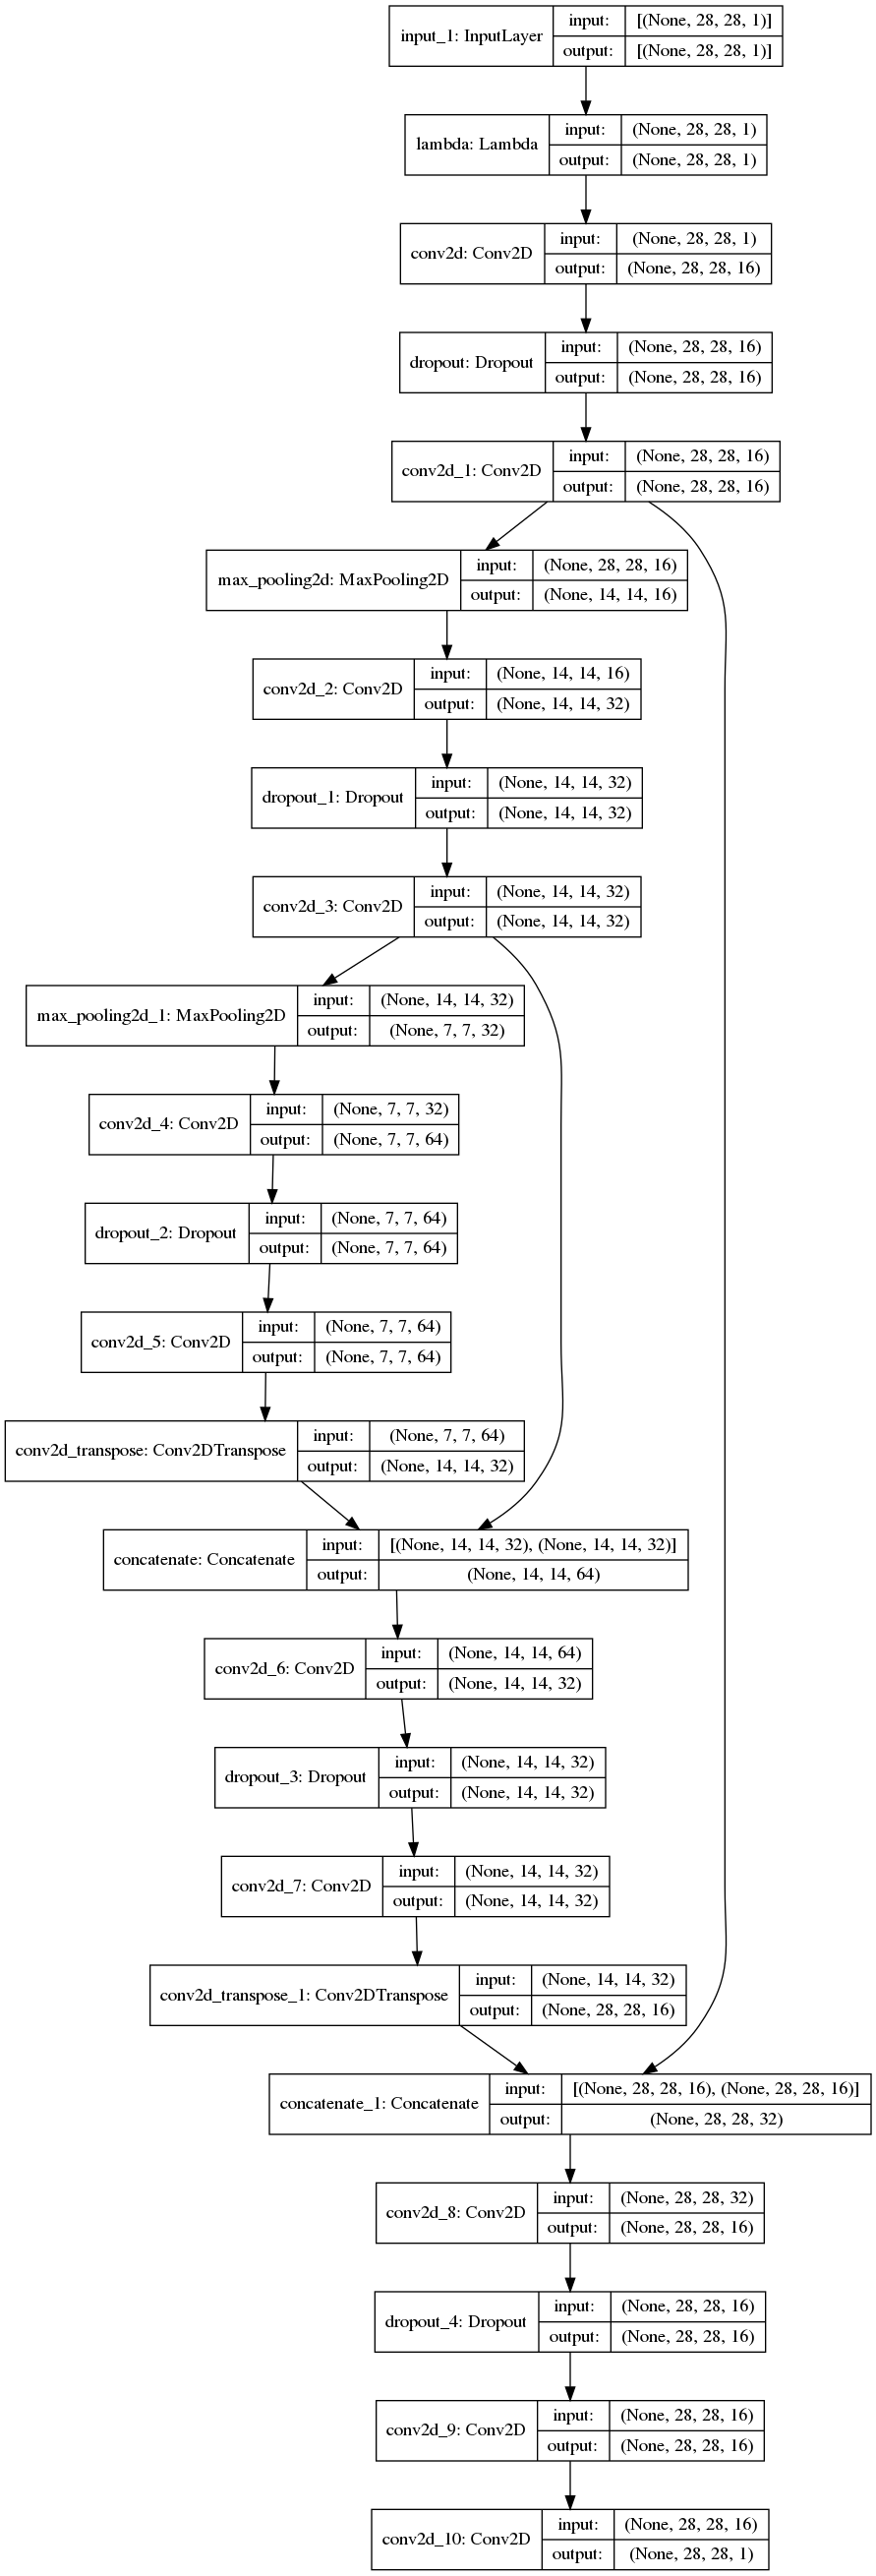

In [6]:

tf.keras.utils.plot_model(
    model, to_file='q2model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

Training the model

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(MODEL_NAME, verbose=1, save_best_only=True)
epochs =  10
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=epochs,callbacks=[earlystopper, checkpointer])


Epoch 1/10
3375/3375 [==============================] - 201s 59ms/step - loss: 0.0202 - acc: 0.9915 - val_loss: 0.0029 - val_acc: 0.9990

Epoch 00001: val_loss improved from inf to 0.00293, saving model to modelq2.h5
Epoch 2/10
3375/3375 [==============================] - 198s 59ms/step - loss: 0.0048 - acc: 0.9979 - val_loss: 0.0027 - val_acc: 0.9988

Epoch 00002: val_loss improved from 0.00293 to 0.00271, saving model to modelq2.h5
Epoch 3/10
3375/3375 [==============================] - 202s 60ms/step - loss: 0.0038 - acc: 0.9984 - val_loss: 0.0023 - val_acc: 0.9990

Epoch 00003: val_loss improved from 0.00271 to 0.00232, saving model to modelq2.h5
Epoch 4/10
3375/3375 [==============================] - 201s 59ms/step - loss: 0.0031 - acc: 0.9987 - val_loss: 0.0024 - val_acc: 0.9990

Epoch 00004: val_loss did not improve from 0.00232
Epoch 5/10
3375/3375 [==============================] - 212s 63ms/step - loss: 0.0027 - acc: 0.9989 - val_loss: 0.0021 - val_acc: 0.9991

Epoch 00005: v

Testing the model

In [7]:
model = load_model(MODEL_NAME)
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

313/313 [==============================] - 7s 21ms/step


Finding the Jaccard Similarity

In [8]:
no_of_test_samples = X_test.shape[0]

total_jac_score = 0
for i in range(no_of_test_samples):
    total_jac_score+= jaccardSimilarity(preds_test_t[i,:,:,0],binary_masks_testX[i])
total_jac_score = total_jac_score /no_of_test_samples
    
print('No of samples in test set are ',no_of_test_samples)
print('Final Jaccard Similarity score for the test set is ', total_jac_score)

No of samples in test set are  10000
Final Jaccard Similarity score for the test set is  0.9934913927361305


Plotting 

In [11]:
from matplotlib import pyplot
def setMatRange(mat):
    max_value = np.max(mat)
    mat = mat / max_value * 255
    return mat

def plotFewBinarySamples(samples,filename):
    for i in range(9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(setMatRange(samples[i]), cmap=pyplot.get_cmap('gray'))
    pyplot.savefig(filename)
    pyplot.show()
    
plotFewBinarySamples(preds_test_t[:,:,:,0],'q2testpred.png')
plotFewBinarySamples(binary_masks_testX,'q2testtrue.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


# Thank You!